In [1]:
import os

exp_dir = f"results/"

os.makedirs(f"{exp_dir}/plots", exist_ok=True)

markers = ["o", "v", "^", "s", "p", "P", "*", "X", "D"]

repeats = 10

scale_factor = 1

In [18]:
# load data

import json
from collections import defaultdict
from datetime import datetime, timezone, timedelta

timings = defaultdict(lambda: defaultdict(list)) # mapping from config json to latency list

config_dirs = [x for x in os.listdir(exp_dir) if x != "plots"]
    
config_dirs.sort(key=lambda x: (x.split("-")[0], int(x.split("-")[1][:-5]), int(x.split("-")[4][:-2]), x))

for config_dir in config_dirs:   
    print(config_dir)
    
    r = 0
    for repeat in os.listdir(f"{exp_dir}/{config_dir}"):
        r += 1
        
        if r > repeats:
            break
            
        # read in configuration.json file and parse
        with open(f"{exp_dir}/{config_dir}/{repeat}/configuration.json", "r") as config_file:
            config = config_file.read()
            j = json.loads(config)
            j["repeat"] = 0

            config = json.dumps(j)

        # read logs of docker-bench
        for bencher in os.listdir(f"{exp_dir}/{config_dir}/{repeat}/logs"):
            if bencher.startswith("bencher"):
                with open(f"{exp_dir}/{config_dir}/{repeat}/logs/{bencher}", "r") as log:
                    if "errors" not in timings[config]:
                        timings[config]["errors"] = {}
                    for line in log.readlines():
                        try:
                            output = json.loads(line)
                        except ValueError:
                            continue

                        start_secs = output["start"]["secs_since_epoch"]
                        start_nanos = output["start"]["nanos_since_epoch"]
                        start = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=start_secs,microseconds=start_nanos/1000)

                        end_secs = output["end"]["secs_since_epoch"]
                        end_nanos = output["end"]["nanos_since_epoch"]
                        end = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=end_secs,microseconds=end_nanos/1000)
    
                        if output["error"]:
                            error = output["error"]
                            if error not in timings[config]["errors"]:
                                timings[config]["errors"][error] = 0
                            timings[config]["errors"][error] += 1
                            continue
                            
                        latency = end - start
                        timings[config]["starts"].append(start)
                        timings[config]["ends"].append(end)
                        timings[config]["latencies"].append((latency / timedelta(microseconds=1))/1000.)
        
        # calculate throughputs
        start = min(timings[config]["starts"])
        end = max(timings[config]["ends"])

        duration = (end - start).total_seconds()
        throughput = len(timings[config]["starts"]) / duration
        timings[config]["throughputs"].append(throughput)
        timings[config]["target_throughput"] = round(1_000_000_000 // j["bencher_interval"], -2)
        
        # clear starts and ends as we don't need them anymore
        del timings[config]["starts"]
        del timings[config]["ends"]
    print("datapoints:", len(timings[config]["latencies"]), "errors:", timings[config]["errors"])

print("loaded", len(timings))    

etcd-3nodes-1benchers-PutRandom-25000ns-100000iters
datapoints: 374944 errors: {'etcdserver: too many requests': 527101, 'etcdserver: request timed out': 97955}
etcd-3nodes-1benchers-PutRandom-28571ns-100000iters
datapoints: 328589 errors: {'etcdserver: too many requests': 544810, 'etcdserver: request timed out': 126601}
etcd-3nodes-1benchers-PutRandom-33333ns-100000iters
datapoints: 319795 errors: {'etcdserver: too many requests': 603735, 'etcdserver: request timed out': 76470}
etcd-3nodes-1benchers-PutRandom-40000ns-100000iters
datapoints: 446893 errors: {'etcdserver: too many requests': 541990, 'etcdserver: request timed out': 11117}
etcd-3nodes-1benchers-PutRandom-50000ns-100000iters
datapoints: 603650 errors: {'etcdserver: too many requests': 396350}
etcd-3nodes-1benchers-PutRandom-66667ns-100000iters
datapoints: 860579 errors: {'etcdserver: too many requests': 139421}
etcd-3nodes-1benchers-PutRandom-100000ns-100000iters
datapoints: 1000000 errors: {}
etcd-3nodes-1benchers-PutRand

datapoints: 995789 errors: {'Timeout expired': 4211}
recetcd-13nodes-1benchers-PutRandom-33333ns-100000iters
datapoints: 987866 errors: {'Timeout expired': 12134}
recetcd-13nodes-1benchers-PutRandom-50000ns-100000iters
datapoints: 988405 errors: {'Timeout expired': 11595}
recetcd-13nodes-1benchers-PutRandom-100000ns-100000iters
datapoints: 987083 errors: {'Timeout expired': 12917}
recetcd-15nodes-1benchers-PutRandom-33333ns-100000iters
datapoints: 981235 errors: {'Timeout expired': 18765}
recetcd-15nodes-1benchers-PutRandom-50000ns-100000iters
datapoints: 981685 errors: {'Timeout expired': 18315}
recetcd-15nodes-1benchers-PutRandom-100000ns-100000iters
datapoints: 992567 errors: {'Timeout expired': 7433}
recetcd-17nodes-1benchers-PutRandom-33333ns-100000iters
datapoints: 974984 errors: {'Timeout expired': 25016}
recetcd-17nodes-1benchers-PutRandom-50000ns-100000iters
datapoints: 988071 errors: {'Timeout expired': 11929}
recetcd-17nodes-1benchers-PutRandom-100000ns-100000iters
datapoint

In [33]:
import pandas

for (key, value) in timings.items():
    print((value.keys()))
    print(type(value["latencies"]))
    print(len(value["latencies"]))
    print(type(value["throughputs"]))
    print(len(value["throughputs"]))

dict_keys(['errors', 'latencies', 'throughputs', 'target_throughput'])
<class 'list'>
374944
<class 'list'>
10
dict_keys(['errors', 'latencies', 'throughputs', 'target_throughput'])
<class 'list'>
328589
<class 'list'>
10
dict_keys(['errors', 'latencies', 'throughputs', 'target_throughput'])
<class 'list'>
319795
<class 'list'>
10
dict_keys(['errors', 'latencies', 'throughputs', 'target_throughput'])
<class 'list'>
446893
<class 'list'>
10
dict_keys(['errors', 'latencies', 'throughputs', 'target_throughput'])
<class 'list'>
603650
<class 'list'>
10
dict_keys(['errors', 'latencies', 'throughputs', 'target_throughput'])
<class 'list'>
860579
<class 'list'>
10
dict_keys(['errors', 'latencies', 'throughputs', 'target_throughput'])
<class 'list'>
1000000
<class 'list'>
10
dict_keys(['errors', 'latencies', 'throughputs', 'target_throughput'])
<class 'list'>
1000000
<class 'list'>
10
dict_keys(['errors', 'latencies', 'throughputs', 'target_throughput'])
<class 'list'>
527317
<class 'list'>
10

In [19]:
for k, v in timings.items():
    print(k, ":", v["errors"])

{"image_name": "quay.io/coreos/etcd:v3.4.13", "repeat": 0, "bench_type": "PutRandom", "cluster_size": 3, "bencher_count": 1, "bencher_total": 100000, "bencher_interval": 25000, "tmpfs": true} : {'etcdserver: too many requests': 527101, 'etcdserver: request timed out': 97955}
{"image_name": "quay.io/coreos/etcd:v3.4.13", "repeat": 0, "bench_type": "PutRandom", "cluster_size": 3, "bencher_count": 1, "bencher_total": 100000, "bencher_interval": 28571, "tmpfs": true} : {'etcdserver: too many requests': 544810, 'etcdserver: request timed out': 126601}
{"image_name": "quay.io/coreos/etcd:v3.4.13", "repeat": 0, "bench_type": "PutRandom", "cluster_size": 3, "bencher_count": 1, "bencher_total": 100000, "bencher_interval": 33333, "tmpfs": true} : {'etcdserver: too many requests': 603735, 'etcdserver: request timed out': 76470}
{"image_name": "quay.io/coreos/etcd:v3.4.13", "repeat": 0, "bench_type": "PutRandom", "cluster_size": 3, "bencher_count": 1, "bencher_total": 100000, "bencher_interval": 4

In [85]:
# success vs errors

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 12,
})

def plot_success_v_errors(bench_type, target_throughput, cluster_sizes = []):
    f = plt.figure()
    f.set_figwidth(6.4 * scale_factor)
    f.set_figheight(4.8 * scale_factor)
    
    index = 0
    
    ls = {} # mapping from legend item to list of datapoints
    df = pandas.DataFrame(data={"image": [], "cluster_size":[], "success": []})
    
    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue
            
        if v["target_throughput"] != target_throughput:
            continue 
            
        cluster_size = config["cluster_size"]
        if cluster_sizes and cluster_size not in cluster_sizes:
            continue
            
        if "quay.io/coreos/etcd" in config["image_name"]:
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif "jeffas/recetcd" in config["image_name"]:
            image = "mergeable-etcd"
        else:
            print("unmatched image name:", config["image_name"])
            
        if image not in ls:
            ls[image] = []
        
        success = len(v["latencies"])

        d = {"image":image, "cluster_size":cluster_size, "success": success}
        for (error, count) in v["errors"].items():
            if "timeout" in error.lower() or "timed out" in error.lower():
                error = "timeout"
            elif "too many" in error.lower():
                error = "overload"
            d[error] = count
        if "timeout" not in d:
            d["timeout"] = 0
        if "overload" not in d:
            d["overload"] = 0
        df = df.append(d, ignore_index=True)
                
    print(df.describe())
    print(df.head())
    
    sns.barplot(data=df, x="cluster_size", y="success", hue="image")
    
#     xs = []
#     etcd_index = 0
#     mergeable_index = 0
#     image_colours = ["tab:blue", "tab:green"]
#     image_index = 0
#     for (image, axes) in ls.items():
#         axes.sort(key=lambda t: t[0])
#         xs, successes, failures = [[ i for i, _, _ in axes ], [ j for _, j, _ in axes ], [k for _, _, k in axes]]
#         linestyle = "--" if "mergeable-etcd" in image else "-"
#         index = 0
#         starts = np.array(xs)
#         width = 0.5
#         gap = 0.2

#         if "mergeable-etcd" in image:
#             index = mergeable_index
#             mergeable_index += 1
#             starts = starts + width / 2 + gap / 2
#         else:
#             index = etcd_index
#             etcd_index += 1
#             starts = starts - width / 2 - gap/2
            
#         plt.bar(starts, successes, width, label=f"{image} success", color=image_colours[image_index])

        
#         bottom = successes
#         error_types = set(k for x in failures for k in x)
#         error_colours = ["tab:red", "tab:orange", "tab:purple", "tab:pink"]
#         error_index = 0
#         for error in error_types:
#             fs = [x[error] if error in x else 0 for x in failures]
#             if "timeout" in error.lower() or "timed out" in error.lower():
#                 error = "timeout"
#             elif "too many" in error.lower():
#                 error = "overload"
#             plt.bar(starts, fs, width, bottom=bottom, label=f"{image} {error}", color=error_colours[image_index * 2 + error_index])
#             bottom = np.array(bottom) + np.array(fs)
#             error_index += 1
#         image_index += 1
        
# #     plt.grid()
# #     plt.title(f"Throughput vs Latency ({bench_type})")
#     plt.xticks(sorted(list(set(xs))))
#     plt.xlabel("Cluster size")
#     plt.ylabel("Number of requests")
#     plt.legend()

#     lower_bench_type = bench_type.lower()
#     plt.savefig(f"{exp_dir}/plots/success-failure-{lower_bench_type}-{target_throughput}.pdf")
#     plt.savefig(f"{exp_dir}/plots/success-failure-{lower_bench_type}-{target_throughput}.svg")

       cluster_size        success     overload       timeout
count     20.000000       20.00000     20.00000     20.000000
mean      12.000000   984360.10000  12602.70000   3037.200000
std        5.893797    27571.48641  28664.45331   4372.524402
min        3.000000   905900.00000      0.00000      0.000000
25%        7.000000   988154.75000      0.00000      0.000000
50%       12.000000   995093.00000      0.00000      0.000000
75%       17.000000  1000000.00000   1155.75000   5108.500000
max       21.000000  1000000.00000  94100.00000  12917.000000
  image  cluster_size    success  overload  timeout
0  etcd           3.0  1000000.0       0.0      0.0
1  etcd           5.0   905900.0   94100.0      0.0
2  etcd           7.0   917096.0   82904.0      0.0
3  etcd           9.0   948590.0   51410.0      0.0
4  etcd          11.0   979783.0   20217.0      0.0
       cluster_size         success       overload        timeout
count     20.000000       20.000000      20.000000      20.00000

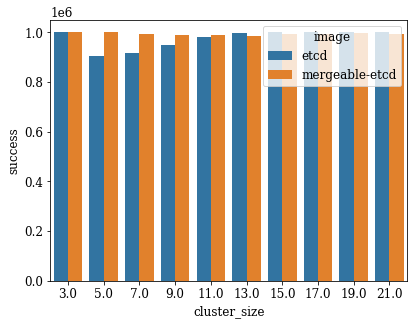

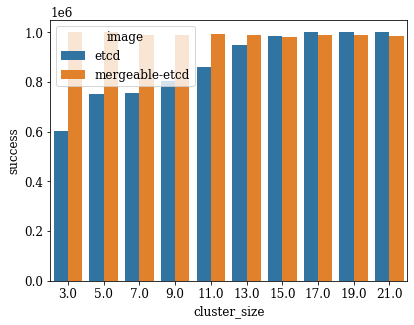

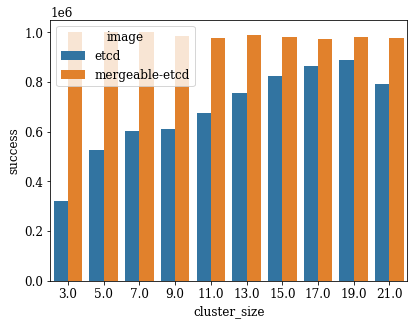

In [86]:
for tp in [10_000, 20_000, 30_000]:
    plot_success_v_errors("PutRandom", tp)

In [6]:
# plot throughput of datastores at differing cluster sizes

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_throughput(bench_type):
    index = 0
    
    ls = {} # mapping from legend item to list of datapoints

    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue
        
        cluster_size = config["cluster_size"]
        if "quay.io/coreos/etcd" in config["image_name"]:
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif "jeffas/recetcd" in config["image_name"]:
            image = "mergeable-etcd"
        else:
            print("unmatched image name:", config["image_name"])
            
        throughput = np.percentile(v["throughputs"], [10, 50, 90])
        
        image += f" {int(v['target_throughput'])}"
        
        if image not in ls:
            ls[image] = {}

        ls[image][cluster_size] = throughput
            
    
    meds = defaultdict(list)
    for (image, sizes) in ls.items():
        for (size, tp) in sizes.items():
            meds[image].append((size, tp))
            
    if not meds:
        return
    
    f = plt.figure()
    f.set_figwidth(6.4 * scale_factor)
    f.set_figheight(4.8 * scale_factor)
                
    xs = []  
    etcd_index = 0
    mergeable_index = 0
    for (image, axes) in meds.items():
        axes.sort(key=lambda t: t[0])
        xs, ys, lows, highs = [[ i for i, j in axes ], [ j[1] for i, j in axes ], [j[0] for i, j in axes], [j[2] for i, j in axes]]
        linestyle = "--" if "mergeable-etcd" in image else "-"
        index = 0
        if "mergeable-etcd" in image:
            index = mergeable_index
            mergeable_index += 1
        else:
            index = etcd_index
            etcd_index += 1
        plt.plot(xs, ys, marker=markers[index % len(markers)], linestyle=linestyle, label=f"{image}")
        plt.fill_between(xs, lows, highs, alpha=0.2)

    plt.grid()
#     plt.title(f"Throughput ({bench_type})")
    plt.ylabel("Achieved throughput (req/s)")
    plt.xlabel("Cluster size")
    plt.xticks(xs)
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/throughput-{lower_bench_type}.pdf")
    plt.savefig(f"{exp_dir}/plots/throughput-{lower_bench_type}.svg")

In [7]:
for ty in ["PutRandom", "PutRange"]:
    plot_throughput(ty)

In [8]:
# throughput vs goodput

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_throughput_v_goodput(bench_type, cluster_sizes = []):
    f = plt.figure()
    f.set_figwidth(6.4 * scale_factor)
    f.set_figheight(4.8 * scale_factor)
    
    index = 0
    
    ls = {} # mapping from legend item to list of datapoints

    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue
        
        cluster_size = config["cluster_size"]
        if cluster_sizes and cluster_size not in cluster_sizes:
            continue
            
        if "quay.io/coreos/etcd" in config["image_name"]:
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif "jeffas/recetcd" in config["image_name"]:
            image = "mergeable-etcd"
        else:
            print("unmatched image name:", config["image_name"])
            
        image += f" x{cluster_size}"
        goodput = np.percentile(v["throughputs"], [10, 50, 90])
        throughput = v["target_throughput"]
                
        if image not in ls:
            ls[image] = []

        ls[image].append((throughput, goodput))
                
    xs = []
    etcd_index = 0
    mergeable_index = 0
    for (image, axes) in ls.items():
        axes.sort(key=lambda t: t[0])
        xs, ys, lows, highs = [[ i for i, j in axes ], [ j[1] for i, j in axes ], [j[0] for i, j in axes], [j[2] for i, j in axes]]

        linestyle = "--" if "mergeable-etcd" in image else "-"
        index = 0
        if "mergeable-etcd" in image:
            index = mergeable_index
            mergeable_index += 1
        else:
            index = etcd_index
            etcd_index += 1
        plt.plot(xs, ys, marker=markers[index % len(markers)], linestyle=linestyle, label=f"{image}")
        plt.fill_between(xs, lows, highs, alpha=0.2)

#     plt.plot(xs, xs, marker=None, linestyle="-.", color="black", label="ideal")

    plt.grid()
#     plt.title(f"Throughput ({bench_type})")
    plt.xlabel("Target Throughput (req/s)")
    plt.ylabel("Achieved Throughput (req/s)")
    plt.xticks(xs)
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/throughput-goodput-{lower_bench_type}.pdf")
    plt.savefig(f"{exp_dir}/plots/throughput-goodput-{lower_bench_type}.svg")

No handles with labels found to put in legend.


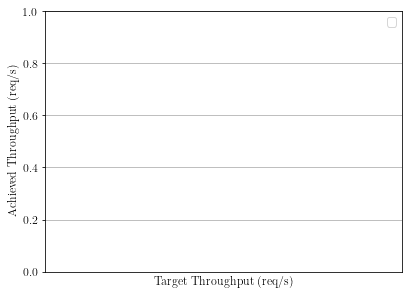

In [9]:
for ty in ["PutRandom"]:
    plot_throughput_v_goodput(ty, [3, 11, 21])

In [10]:
# throughput vs latency

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_throughput_v_latency(bench_type, cluster_sizes = []):
    f = plt.figure()
    f.set_figwidth(6.4 * scale_factor)
    f.set_figheight(4.8 * scale_factor)
    
    index = 0
    
    ls = {} # mapping from legend item to list of datapoints

    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue
        
        cluster_size = config["cluster_size"]
        if cluster_sizes and cluster_size not in cluster_sizes:
            continue
            
        if "quay.io/coreos/etcd" in config["image_name"]:
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif "jeffas/recetcd" in config["image_name"]:
            image = "mergeable-etcd"
        else:
            print("unmatched image name:", config["image_name"])
            
        image += f" x{cluster_size}"
        target_throughput = v["target_throughput"]
        throughput = np.median(v["throughputs"])
        latencies = v["latencies"]
        latency = np.percentile(latencies, [50])[0]
        
        if image not in ls:
            ls[image] = []

        ls[image].append((target_throughput, throughput, latency))
                
    xs = []
    etcd_index = 0
    mergeable_index = 0
    for (image, axes) in ls.items():
        axes.sort(key=lambda t: t[0])
        xs, ys = [[ i for _, i, j in axes ], [ j for _, i, j in axes ]]
        linestyle = "--" if "mergeable-etcd" in image else "-"
        index = 0
        if "mergeable-etcd" in image:
            index = mergeable_index
            mergeable_index += 1
        else:
            index = etcd_index
            etcd_index += 1
        plt.plot(xs, ys, marker=markers[index % len(markers)], linestyle=linestyle, label=f"{image}")
        
    plt.grid()
#     plt.title(f"Throughput vs Latency ({bench_type})")
    plt.xlabel("Achieved Throughput (req/s)")
    plt.ylabel("Latency (ms)")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/latency-throughput-{lower_bench_type}.pdf")
    plt.savefig(f"{exp_dir}/plots/latency-throughput-{lower_bench_type}.svg")

No handles with labels found to put in legend.


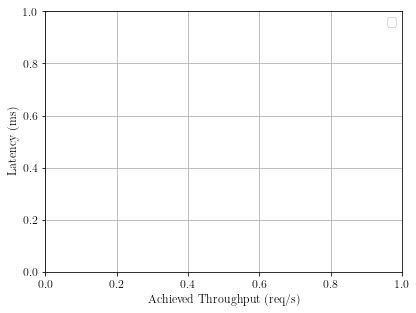

In [11]:
plot_throughput_v_latency("PutRandom", [3, 11, 21])

In [12]:
# latency cdfs plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_cdf(bench_type, cluster_size, target_throughput):
    index = 0
    
    grouped_latencies = defaultdict(list)     

    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue
        
        if v["target_throughput"] != target_throughput:
            continue

        if config["cluster_size"] == cluster_size:
            latencies = v["latencies"]
            
            del config["repeat"]
            k = json.dumps(config)
            grouped_latencies[k] += latencies
            
    if not grouped_latencies:
        return
    
    f = plt.figure()
    f.set_figwidth(6.4 * scale_factor)
    f.set_figheight(4.8 * scale_factor)
    
    for (k, v) in grouped_latencies.items():
        config = json.loads(k)
        if "quay.io/coreos/etcd" in config["image_name"]:
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif "jeffas/recetcd" in config["image_name"]:
            image = "mergeable-etcd"
        else:
            print("unmatched image name:", config["image_name"])
        
        latencies = v
        latencies.sort()
        size = len(latencies)
        ys = np.array(range(size))/ float(size)
        plt.plot(latencies, ys, label=f"{image} x{cluster_size}")
        index += 1
        
    plt.grid()
#     plt.title(f"Latency CDF ({bench_type})")
    plt.xlabel("Request duration (ms)")
    plt.ylabel("Probability")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/latency-cdf-{lower_bench_type}-{cluster_size}.pdf")
    plt.savefig(f"{exp_dir}/plots/latency-cdf-{lower_bench_type}-{cluster_size}.svg")

In [13]:
for ty in ["PutRange", "PutRandom"]:
    for size in range(1, 25, 2):
        plot_cdf(ty, size, 20_000)

In [14]:
# latency cdfs plots grouping cluster size

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_cdf_grouped(bench_type, cluster_sizes, target_throughput):
    index = 0
    
    grouped_latencies = defaultdict(list)     

    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue
        
        if v["target_throughput"] != target_throughput:
            continue

        if config["cluster_size"] in cluster_sizes:
            latencies = v["latencies"]
            
            del config["repeat"]
            k = json.dumps(config)
            grouped_latencies[k] += latencies
            
    if not grouped_latencies:
        return
            
    f = plt.figure()
    f.set_figwidth(6.4 * scale_factor)
    f.set_figheight(4.8 * scale_factor)
            
    for (k, v) in grouped_latencies.items():
        config = json.loads(k)
        if "quay.io/coreos/etcd" in config["image_name"]:
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif "jeffas/recetcd" in config["image_name"]:
            image = "mergeable-etcd"
        else:
            print("unmatched image name:", config["image_name"])
        
        latencies = v
        latencies.sort()
        step = len(latencies) // 1000
        latencies = latencies[::step]
        size = len(latencies)
        ys = np.array(range(size)) / float(size)
        linestyle = "--" if "mergeable-etcd" in image else "-"
        
        plt.plot(latencies, ys, linestyle=linestyle, label=f"{image} x{config['cluster_size']}")
        index += 1
        
    plt.grid()
#     plt.title(f"Latency CDF ({bench_type})")
    plt.xlabel("Request duration (ms)")
    plt.ylabel("Probability")
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/latency-cdf-grouped-{lower_bench_type}-{cluster_sizes}-{target_throughput}.pdf")
    plt.savefig(f"{exp_dir}/plots/latency-cdf-grouped-{lower_bench_type}-{cluster_sizes}-{target_throughput}.svg")

In [15]:
for tp in [10_000, 20_000, 30_000]:
    print(f"target throughput: {tp}")
    for ty in ["PutRandom"]:
        plot_cdf_grouped(ty, [3, 11, 21], tp)

target throughput: 10000
target throughput: 20000
target throughput: 30000


In [16]:
# plot percentile latencies of datastores at differing cluster sizes

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

def plot_latency_percentiles_fill(bench_type, percentiles, target_throughput):
    index = 0
    
    ls = {} # mapping from legend item to list of datapoints
    
    for (k, v) in timings.items():
        config = json.loads(k)
        if config["bench_type"] != bench_type:
            continue
            
        if v["target_throughput"] != target_throughput:
            continue
        
        cluster_size = config["cluster_size"]
        if cluster_size == 1:
            continue
        if "quay.io/coreos/etcd" in config["image_name"]:
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif "jeffas/recetcd" in config["image_name"]:
            image = "mergeable-etcd"
        else:
            print("unmatched image name:", config["image_name"])
            
        latencies = v["latencies"]
        
#         image += str(v["target_throughput"])
        
        if image not in ls:
            ls[image] = {}
        if cluster_size not in ls[image]:
            ls[image][cluster_size] = []
        ls[image][cluster_size] += latencies
            
    
    meds = defaultdict(list)

    for (image, sizes) in ls.items():
        for (size, latencies) in sizes.items():
            ps = np.percentile(latencies, percentiles)
            meds[image].append((size, ps))
            
    if not meds:
        return
    
    f = plt.figure()
    f.set_figwidth(6.4 * scale_factor)
    f.set_figheight(4.8 * scale_factor)
                
    xs = []      
    for (image, axes) in meds.items():
        axes.sort(key=lambda t: t[0])
        xs, ys, lows, highs = [[i for i, j in axes], [j[1] for i, j in axes], [j[0] for i, j in axes], [j[2] for i, j in axes]]
        plt.plot(xs, ys, marker=markers[index % len(markers)], label=f"{image}")
        plt.fill_between(xs, lows, highs, alpha=0.2)
        index += 1
        
    plt.grid()
#     plt.title(f"Latency ({bench_type})")
    plt.ylabel("Request duration (ms)")
    plt.xlabel("Cluster size")
    plt.xticks(xs)
    plt.legend()

    lower_bench_type = bench_type.lower()
    plt.savefig(f"{exp_dir}/plots/latency-percentiles-fill-{lower_bench_type}-{percentiles}-{target_throughput}.pdf")
    plt.savefig(f"{exp_dir}/plots/latency-percentiles-fill-{lower_bench_type}-{percentiles}-{target_throughput}.svg")

In [17]:
for tp in [10_000, 20_000, 30_000]:
    print(f"target throughput: {tp}")
    for ty in ["PutRandom", "PutRange"]:
        print(f"type: {ty}")
        for bounds in [[25, 50, 75], [10, 50, 90], [1, 50, 99]]:
            print(f"bounds: {bounds}")
            plot_latency_percentiles_fill(ty, bounds, tp)

target throughput: 10000
type: PutRandom
bounds: [25, 50, 75]
bounds: [10, 50, 90]
bounds: [1, 50, 99]
type: PutRange
bounds: [25, 50, 75]
bounds: [10, 50, 90]
bounds: [1, 50, 99]
target throughput: 20000
type: PutRandom
bounds: [25, 50, 75]
bounds: [10, 50, 90]
bounds: [1, 50, 99]
type: PutRange
bounds: [25, 50, 75]
bounds: [10, 50, 90]
bounds: [1, 50, 99]
target throughput: 30000
type: PutRandom
bounds: [25, 50, 75]
bounds: [10, 50, 90]
bounds: [1, 50, 99]
type: PutRange
bounds: [25, 50, 75]
bounds: [10, 50, 90]
bounds: [1, 50, 99]
